Punto 1

# Encoder


📷 Información de la imagen: 1353x1600 píxeles
📦 Capacidad máxima de mensaje: 270600 caracteres
📝 Longitud del mensaje actual: 445 caracteres

🚀 Ocultando mensaje: 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'

✅ Imagen guardada correctamente como 'imagen_estego.png'



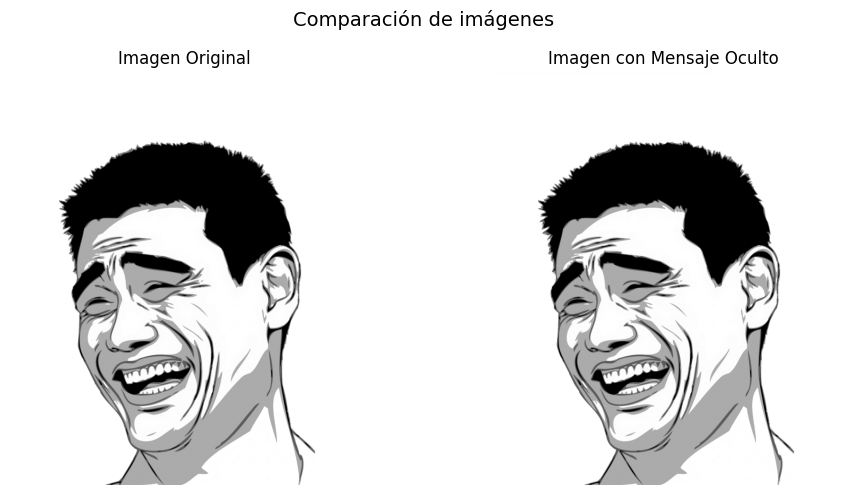

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def mensaje_a_binario(mensaje):
    mensaje += "&"  # Marcador de fin
    return ''.join([format(ord(c), '08b') for c in mensaje])

def ocultar_mensaje(imagen_path, mensaje, salida_path):
    try:
        imagen = Image.open(imagen_path).convert('L')  # Escala de grises
        datos = np.array(imagen).flatten()
        bin_mensaje = mensaje_a_binario(mensaje)
        
        if len(bin_mensaje) > len(datos):
            max_chars = len(datos) // 8
            raise ValueError(f"El mensaje es muy largo para esta imagen. Máximo: {max_chars} caracteres")
        
        for i, bit in enumerate(bin_mensaje):
            datos[i] = (datos[i] & 0b11111110) | int(bit)

        nueva_imagen = Image.fromarray(np.reshape(datos, imagen.size[::-1]).astype(np.uint8))
        nueva_imagen.save(salida_path)
        
        print(f"\n✅ Imagen guardada correctamente como '{salida_path}'\n")
        return imagen, nueva_imagen
        
    except Exception as e:
        print(f"Error al ocultar mensaje: {str(e)}")
        return None, None

# === MAIN (ENCODER) ===
if __name__ == "__main__":
    imagen_original = "imagen_portadora.png"
    imagen_estego = "imagen_estego.png"
    mensaje = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

    imagen = Image.open(imagen_original).convert('L')
    capacidad = (imagen.size[0] * imagen.size[1]) // 8
    print(f"\n📷 Información de la imagen: {imagen.size[0]}x{imagen.size[1]} píxeles")
    print(f"📦 Capacidad máxima de mensaje: {capacidad} caracteres")
    print(f"📝 Longitud del mensaje actual: {len(mensaje)} caracteres")
    
    print(f"\n🚀 Ocultando mensaje: '{mensaje}'")
    imagen_orig, imagen_mod = ocultar_mensaje(imagen_original, mensaje, imagen_estego)
    
    if imagen_orig is not None and imagen_mod is not None:
        # Comparación visual
        plt.figure(figsize=(10, 5))
        plt.suptitle("Comparación de imágenes", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(imagen_orig, cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(imagen_mod, cmap='gray')
        plt.title('Imagen con Mensaje Oculto')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Punto 1  

# Decoder

In [ ]:
def binario_a_mensaje(bin_str):
    chars = [bin_str[i:i+8] for i in range(0, len(bin_str), 8)]
    mensaje = ''
    for byte in chars:
        char = chr(int(byte, 2))
        if char == '&':
            break
        mensaje += char
    return mensaje

def extraer_mensaje(imagen_path):
    try:
        imagen = Image.open(imagen_path).convert('L')
        datos = np.array(imagen).flatten()
        bits = ''.join([str(pixel & 1) for pixel in datos])
        return binario_a_mensaje(bits)
    except Exception as e:
        print(f"Error al extraer mensaje: {str(e)}")
        return None

# === MAIN (DECODER) ===
if __name__ == "__main__":
    imagen_estego = "imagen_estego.png"
    
    print(f"📂 Leyendo imagen estego desde: {imagen_estego}")
    mensaje_recuperado = extraer_mensaje(imagen_estego)

    print("\n🕵️ Mensaje recuperado:")
    print("───────────────────────────────")
    print(mensaje_recuperado)
    print("───────────────────────────────")


📂 Leyendo imagen estego desde: imagen_estego.png

🕵️ Mensaje recuperado:
───────────────────────────────
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
───────────────────────────────


Punto 2 (opción 1):

Estamos sólo invirtiendo la parte imaginaria de los coeficientes de la FFT, invertir ambos rompe la imagen estego y arruina la recuperada. 

En las dos opciones, estamos usando variables shape_hidden y posiciones para saber cuánto codificar en la reconstrucción. Probamos otros métodos (ocultar la información en los primeros pixeles de la imagen estego, pero no ha funcionado). La otra opción es hardcodear los tamaños de la imagen a recuperar (dejar establecido de manera fija el valor). Lo mismo posiciones, que contiene la lista de posiciones de las frecuencias modificadas. Acá es más complicado hardcodear porque las generamos aleatoriamente.

# Encoder

In [ ]:
def cargar_grises(path):
    return np.array(Image.open(path).convert('L'))

def obtener_posiciones_validas(shape, radio_exclusion=40, n=0):
    h, w = shape
    centro = (h // 2, w // 2)
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    dist = np.sqrt((Y - centro[0]) ** 2 + (X - centro[1]) ** 2)
    mask = dist > radio_exclusion
    indices = np.argwhere(mask)
    posiciones = []
    usados = set()
    for i, j in indices:
        ci, cj = (-i) % h, (-j) % w
        if (ci, cj) not in usados and (i, j) not in usados and (i, j) < (ci, cj):
            posiciones.append((i, j, ci, cj))
            usados.add((i, j))
            usados.add((ci, cj))
    np.random.shuffle(posiciones)
    return posiciones[:n]

def ocultar_fft_grises(carrier, hidden, rep=3):
    carrier_f = np.fft.fft2(carrier)
    
    # Expandir cada píxel a sus 8 bits
    bits = np.unpackbits(hidden.flatten())  # shape: (N_pixeles * 8,)
    bits_rep = np.repeat(bits, rep)

    posiciones = obtener_posiciones_validas(carrier.shape, radio_exclusion=40, n=len(bits_rep))

    for idx, bit in enumerate(bits_rep):
        i, j, ci, cj = posiciones[idx]
        val = carrier_f[i, j]
        # Signo positivo si bit=1, negativo si bit=0
        imag = abs(val.imag) if bit == 1 else -abs(val.imag)
        carrier_f[i, j] = complex(val.real, imag)
        carrier_f[ci, cj] = complex(val.real, -imag)

    estego = np.real(np.fft.ifft2(carrier_f))
    estego = np.clip(estego, 0, 255).astype(np.uint8)
    return estego, posiciones

# === ENCODER ===
portadora = cargar_grises('globo.png')
oculta = cargar_grises('wp.png')
rep = 7

estego, posiciones = ocultar_fft_grises(portadora, oculta, rep=rep)
Image.fromarray(estego).save("imagen_estego.tiff", format='TIFF')

print(f"\n✅ Imagen '{'wp.png'}' ocultada correctamente en 'imagen_estego.tiff'.")
print(f"🧠 Total de bits ocultos (con redundancia): {len(posiciones)}\n")



✅ Imagen 'wp.png' ocultada correctamente en 'imagen_estego.tiff'.
🧠 Total de bits ocultos (con redundancia): 3670016



Punto 2 (opción 1)
Sólo modificar el componente imaginario.

# Decoder 

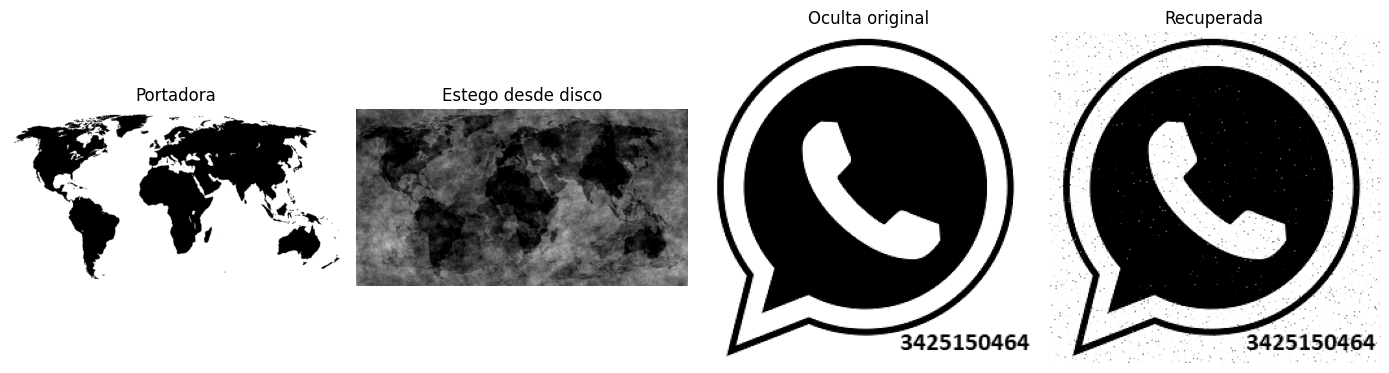


🔍 Submatriz de 20x20 píxeles (valores enteros)

🧩 Original (wp.png):
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 

In [ ]:
def cargar_grises(path):
    return np.array(Image.open(path).convert('L'))

def extraer_fft_grises(estego, shape_hidden, posiciones, rep=3):
    estego_f = np.fft.fft2(estego)
    bits_extraidos = []

    for i, j, _, _ in posiciones:
        val = estego_f[i, j]
        bit = 1 if val.imag >= 0 else 0
        bits_extraidos.append(bit)

    # Votación mayoritaria
    bits = []
    for i in range(0, len(bits_extraidos), rep):
        votos = bits_extraidos[i:i+rep]
        bits.append(int(np.sum(votos) >= (rep / 2)))

    # Reconstrucción
    bits_array = np.array(bits[:shape_hidden[0]*shape_hidden[1]*8], dtype=np.uint8)
    pixels = np.packbits(bits_array).reshape(shape_hidden)
    return pixels

# === DECODER ===
portadora = cargar_grises('globo.png')
oculta = cargar_grises('wp.png')
estego_cargada = cargar_grises("imagen_estego.tiff")
rep = 7

# Las posiciones vienen del encoder, no se usan archivos auxiliares
recuperada = extraer_fft_grises(estego_cargada, oculta.shape, posiciones, rep=rep)

# Visualización de imágenes
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(portadora, cmap='gray'); axs[0].set_title("Portadora")
axs[1].imshow(estego_cargada, cmap='gray'); axs[1].set_title("Estego desde disco")
axs[2].imshow(oculta, cmap='gray'); axs[2].set_title("Oculta original")
axs[3].imshow(recuperada, cmap='gray'); axs[3].set_title("Recuperada")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

# === ANÁLISIS COMPARATIVO EN CONSOLA ===
print("\n🔍 Submatriz de 20x20 píxeles (valores enteros)\n")

# Recorte superior izquierdo
oculta_20x20 = oculta[:20, :20]
recuperada_20x20 = recuperada[:20, :20]

print("🧩 Original (wp.png):")
print(oculta_20x20)

print("\n🎯 Recuperada:")
print(recuperada_20x20)

# Métricas
iguales = np.sum(oculta == recuperada)
total = oculta.size
porcentaje_igual = 100 * iguales / total
ecm = np.mean((oculta.astype(np.int32) - recuperada.astype(np.int32))**2)

print(f"\n✅ Coincidencia total de píxeles: {iguales}/{total} ({porcentaje_igual:.2f}%)")
print(f"📉 Error cuadrático medio (ECM): {ecm:.2f}")


Punto 2: inviertiendo los signos de ambos componentes.

# Funciones comunes

In [ ]:
def cargar_grises(path):
    return np.array(Image.open(path).convert('L'))

def obtener_posiciones_validas(shape, radio_exclusion=40, n=0):
    h, w = shape
    centro = (h // 2, w // 2)
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    dist = np.sqrt((Y - centro[0]) ** 2 + (X - centro[1]) ** 2)
    mask = dist > radio_exclusion
    indices = np.argwhere(mask)
    posiciones = []
    usados = set()
    for i, j in indices:
        ci, cj = (-i) % h, (-j) % w
        if (ci, cj) not in usados and (i, j) not in usados and (i, j) < (ci, cj):
            posiciones.append((i, j, ci, cj))
            usados.add((i, j))
            usados.add((ci, cj))
    np.random.shuffle(posiciones)
    return posiciones[:n]


Punto 2 (opción 2)

# Encoder

Invertimos los signos en la parte real e imaginaria de la FFT de la imagen portadora.
Requiere más repeticiones para la votación mayoritaria y, por supuesto, más pixeles en la imagen portadora vs la oculta.
El resultado es menos satisfactorio que el anterior.

In [ ]:
def ocultar_fft_grises_ambos_signos(carrier, hidden, rep=1):
    carrier_f = np.fft.fft2(carrier)

    bits = np.unpackbits(hidden.flatten())  # bits: (N_pixeles * 8,)
    bits_rep = np.repeat(bits, rep)

    posiciones = obtener_posiciones_validas(carrier.shape, radio_exclusion=40, n=len(bits_rep))

    for idx, bit in enumerate(bits_rep):
        i, j, ci, cj = posiciones[idx]
        val = carrier_f[i, j]

        if bit == 1:
            real = abs(val.real)
            imag = abs(val.imag)
        else:
            real = -abs(val.real)
            imag = -abs(val.imag)

        carrier_f[i, j] = complex(real, imag)
        carrier_f[ci, cj] = complex(real, -imag)

    estego = np.real(np.fft.ifft2(carrier_f))
    estego = np.clip(estego, 0, 255).astype(np.uint8)
    return estego, posiciones

# === ENCODER ===
portadora = cargar_grises('globo.png')
oculta = cargar_grises('wp.png')
rep = 7

estego, posiciones = ocultar_fft_grises_ambos_signos(portadora, oculta, rep=rep)
Image.fromarray(estego).save("imagen_estego.tiff", format='TIFF')

print(f"\n✅ Imagen '{'wp.png'}' ocultada correctamente en 'imagen_estego.tiff'.")
print(f"🧠 Total de bits ocultos (con redundancia): {len(posiciones)}\n")



✅ Imagen 'wp.png' ocultada correctamente en 'imagen_estego.tiff'.
🧠 Total de bits ocultos (con redundancia): 3670016



Parte 2:

# Decoder

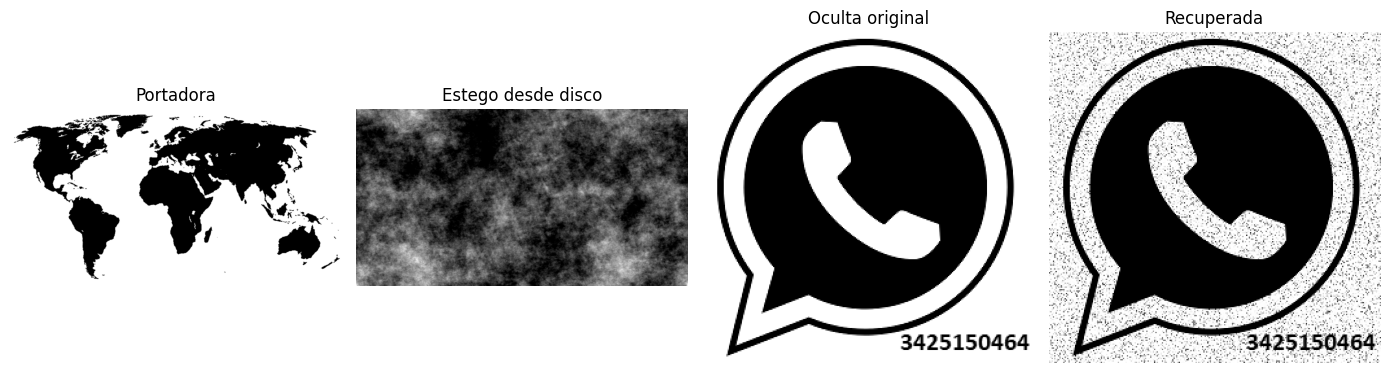


=== Matriz Oculta original (20x20) ===
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255

In [ ]:
def extraer_fft_grises_ambos_signos(estego, shape_hidden, posiciones, rep):
    estego_f = np.fft.fft2(estego)
    bits_extraidos = []

    for i, j, _, _ in posiciones:
        val = estego_f[i, j]
        bit = 1 if val.real >= 0 and val.imag >= 0 else 0
        bits_extraidos.append(bit)

    # Votación por grupos
    bits = []
    for i in range(0, len(bits_extraidos), rep):
        votos = bits_extraidos[i:i+rep]
        bits.append(int(np.sum(votos) >= (rep / 2)))

    bits_array = np.array(bits[:shape_hidden[0]*shape_hidden[1]*8], dtype=np.uint8)
    pixels = np.packbits(bits_array).reshape(shape_hidden)
    return pixels

# === DECODER ===
portadora = cargar_grises('globo.png')
oculta = cargar_grises('wp.png')  # solo para shape
estego_cargada = cargar_grises("imagen_estego.tiff")
rep = 7

recuperada = extraer_fft_grises_ambos_signos(estego_cargada, oculta.shape, posiciones, rep=rep)

# Visualización
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(portadora, cmap='gray'); axs[0].set_title("Portadora")
axs[1].imshow(estego_cargada, cmap='gray'); axs[1].set_title("Estego desde disco")
axs[2].imshow(oculta, cmap='gray'); axs[2].set_title("Oculta original")
axs[3].imshow(recuperada, cmap='gray'); axs[3].set_title("Recuperada")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

# Comparación numérica
print("\n=== Matriz Oculta original (20x20) ===")
print(oculta[:20, :20])
print("\n=== Matriz Oculta recuperada (20x20) ===")
print(recuperada[:20, :20])

diff = np.abs(oculta.astype(int) - recuperada.astype(int))
max_diff = np.max(diff)
mean_diff = np.mean(diff)
eq_pix = np.sum(oculta == recuperada)
porcentaje = 100 * eq_pix / oculta.size

print("\n=== Comparación cuantitativa ===")
print(f"Máxima diferencia absoluta: {max_diff}")
print(f"Diferencia media: {mean_diff:.2f}")
print(f"Porcentaje de píxeles exactamente iguales: {porcentaje:.2f}%")

Punto 3

# Código común: funciones

In [ ]:

import imageio.v3 as iio

def cargar_grises(path):
    return np.array(Image.open(path).convert("L"), dtype=np.float64)

def ocultar(portadora, oculta, delta, rep):
    # Transformada de Fourier con shift centrado
    tf = np.fft.fftshift(np.fft.fft2(portadora))
    real = np.real(tf).flatten()
    imag = np.imag(tf).flatten()

    bits = np.unpackbits(oculta.astype(np.uint8).flatten())
    bits_rep = np.repeat(bits, rep)

    capacidad = min(len(bits_rep), len(real) + len(imag))
    bits_rep = bits_rep[:capacidad]

    real_mod = real.copy()
    imag_mod = imag.copy()
    idx_real = idx_imag = 0

    for i, bit in enumerate(bits_rep):
        if i % 2 == 0:
            a = real_mod[idx_real]
            signo = 1 if a >= 0 else -1
            q = int(np.round(abs(a) / delta))
            if q % 2 != bit:
                q += 1 if q % 2 == 0 else -1
            real_mod[idx_real] = signo * q * delta
            idx_real += 1
        else:
            b = imag_mod[idx_imag]
            signo = 1 if b >= 0 else -1
            q = int(np.round(abs(b) / delta))
            if q % 2 != bit:
                q += 1 if q % 2 == 0 else -1
            imag_mod[idx_imag] = signo * q * delta
            idx_imag += 1

    tf_mod = (real_mod + 1j * imag_mod).reshape(portadora.shape)
    tf_mod = np.fft.ifftshift(tf_mod)
    estego = np.fft.ifft2(tf_mod)
    estego = np.real(estego)
    estego = np.clip(estego, 0, 255)
    
    return estego.astype(np.float32)

def extraer(estego, delta, rep, shape_recuperada):
    tf = np.fft.fftshift(np.fft.fft2(estego))
    real = np.real(tf).flatten()
    imag = np.imag(tf).flatten()
    total_bits = shape_recuperada[0] * shape_recuperada[1] * 8
    total_bits_rep = total_bits * rep

    bits_extraidos = []
    idx_real = idx_imag = 0

    for i in range(total_bits_rep):
        if i % 2 == 0:
            a = real[idx_real]
            idx_real += 1
        else:
            a = imag[idx_imag]
            idx_imag += 1
        q = int(np.round(abs(a) / delta))
        bits_extraidos.append(q % 2)

    bits_finales = []
    for i in range(0, len(bits_extraidos), rep):
        bloque = bits_extraidos[i:i+rep]
        if len(bloque) < rep:
            break
        bit = int(np.sum(bloque) >= (rep // 2 + 1))
        bits_finales.append(bit)

    bits_finales = np.array(bits_finales[: (len(bits_finales) // 8) * 8])
    pixeles = np.packbits(bits_finales)
    return pixeles[:shape_recuperada[0] * shape_recuperada[1]].reshape(shape_recuperada)

Punto 3

# ENCODER

In [ ]:
# Parámetros
delta = 100
rep = 3

# Carga imágenes
portadora = cargar_grises("imagen_portadora.png")
oculta = cargar_grises("wp.png")

shape_oculta_original = oculta.shape

# Ocultar
estego = ocultar(portadora, oculta, delta=delta, rep=rep)
iio.imwrite("imagen_estego.tiff", estego.astype(np.float32))

print("✅ La imagen ha sido procesada y guardada como imagen_estego.tiff")
print(f"ℹ️ Dimensiones ocultas originales: {shape_oculta_original}")

✅ La imagen ha sido procesada y guardada como imagen_estego.tiff
ℹ️ Dimensiones ocultas originales: (256, 256)


Punto 3

# Decoder

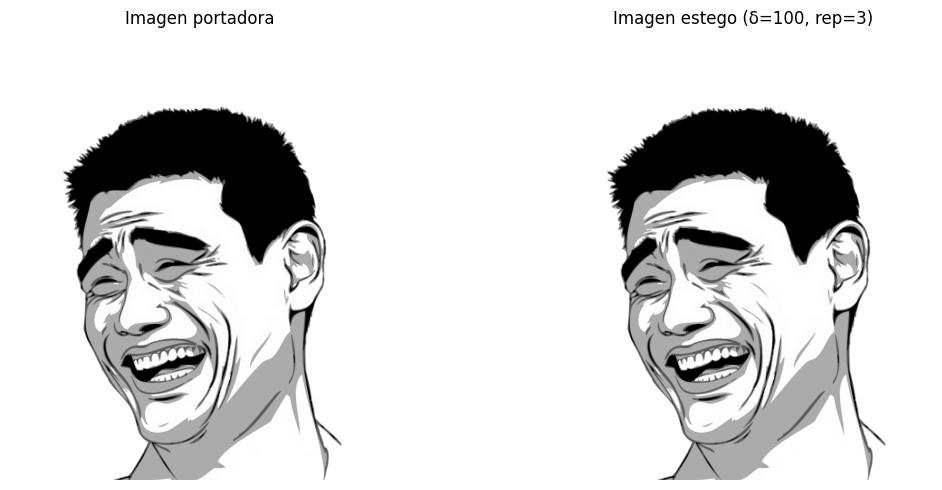

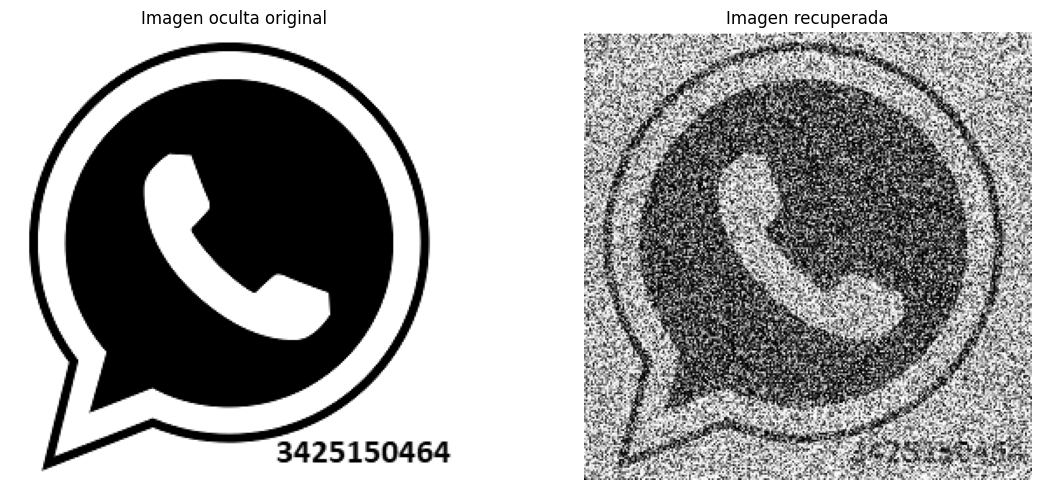


🔍 Bloques 20x20 de la imagen oculta original (valores enteros):
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255]


In [ ]:
# Parámetros
delta = 100
rep = 3
shape_recuperada = oculta.shape  # Debemos tener estas dimensiones para recuperar bien

# Cargar imagen estego
estego_leida = iio.imread("imagen_estego.tiff").astype(np.float64)

# Extraer imagen oculta
recuperada = extraer(estego_leida, delta=delta, rep=rep, shape_recuperada=shape_recuperada)

# Mostrar portadora y estego
fig1, axs1 = plt.subplots(1, 2, figsize=(12, 5))
axs1[0].imshow(portadora, cmap='gray')
axs1[0].set_title("Imagen portadora")
axs1[1].imshow(estego_leida, cmap='gray', vmin=0, vmax=255)
axs1[1].set_title(f"Imagen estego (δ={delta}, rep={rep})")
for ax in axs1:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Mostrar oculta original y recuperada
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5))
axs2[0].imshow(oculta, cmap='gray', vmin=0, vmax=255)
axs2[0].set_title("Imagen oculta original")
axs2[1].imshow(recuperada, cmap='gray', vmin=0, vmax=255)
axs2[1].set_title("Imagen recuperada")
for ax in axs2:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Mostrar 20x20 bloques y comparación simple
print("\n🔍 Bloques 20x20 de la imagen oculta original (valores enteros):")
print(oculta[:20, :20].astype(int))

print("\n🔍 Bloques 20x20 de la imagen recuperada (valores enteros):")
print(recuperada[:20, :20].astype(int))

# Análisis comparativo: porcentaje de píxeles idénticos en el bloque 20x20
original_block = oculta[:20, :20].astype(int)
recuperado_block = recuperada[:20, :20].astype(int)
iguales = np.sum(original_block == recuperado_block)
total = original_block.size
print(f"\n📊 Coincidencia píxeles en bloque 20x20: {iguales}/{total} = {iguales/total*100:.2f}%")